In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt

In [47]:
train = pd.read_csv('../../input/train_V2.csv')
test = pd.read_csv('../../input/test_V2.csv')

In [213]:
group_lvl_features = pd.read_csv('../../input/groupLevelFeatures_train.csv')
group_lvl_features_test = pd.read_csv('../../input/groupLevelFeatures_test.csv')

In [210]:
def compute_dcg(ordered_relevance):
    
    dcg = 0
    for i in range(len(ordered_relevance)):
        numerator = ordered_relevance[i,1]
        denomenator = np.log2(i + 2)
        dcg += numerator/denomenator
        
        
    return dcg

def ndcg(match_expectations, match_predictions, rank=None): 
    a = match_expectations.reshape(len(match_expectations),1)
    b = match_predictions.reshape(len(match_predictions),1)
    combined_values = np.hstack((a,b))
    
    ordered_relevance = combined_values[combined_values[:,0].argsort()[::-1]]    
    dcg = compute_dcg(combined_values)
    
    ideal_combination = np.hstack((a,a))
    idcg = compute_dcg(ideal_combination)
    
    return dcg/idcg
        
    

## Make sure the prediction output order is similar to data input order.
ndcg(np.array([3,3,3,2,2,2]),np.array([4,3,3,2,2,2]))

1.1144130414141749

In [271]:
def getWinPlacePerc(dataset, predictions):
    concatenated = pd.concat([dataset.reset_index(), pd.DataFrame({'Predicted': predictions})], axis=1)    
    concatenated['rank'] = concatenated.groupby('matchId')['Predicted'].rank(method='dense')
    concatenated['pr_winPlacePerc'] = (concatenated['rank'] - 1) / (concatenated['maxPlace'] - 1)
    return concatenated

In [191]:
feature_list = group_lvl_features.columns[2:]

In [90]:
X = group_lvl_features[group_lvl_features.columns.intersection(feature_list)]
y = group_lvl_features.merge(train[['groupId','maxPlace','winPlacePerc']], on='groupId', how='inner').drop_duplicates().reset_index()
y['winPlacePerc'] = y['winPlacePerc'].fillna(0)

In [100]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [99]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_n = scaler.fit_transform(X_train)

/miniconda2/envs/AML/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/miniconda2/envs/AML/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [254]:
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import KFold

kf = KFold(n_splits=5)

train_mae = list()
train_ndcg = list()
test_mae = list()
test_ndcg = list()

for train_index, test_index in kf.split(X_train):

    train_f, train_l = X_train_n[train_index], y_train.iloc[train_index]
    test_f, test_l = X_train_n[test_index], y_train.iloc[test_index]#.values
    
    reg = LinearRegression().fit(train_f, train_l['winPlacePerc'].values)
    
    trainMergedScoreRank = getWinPlacePerc(train_l,reg.predict(train_f))
    testMergedScoreRank = getWinPlacePerc(test_l,reg.predict(test_f))
    
    train_pred = trainMergedScoreRank['pr_winPlacePerc'].values
    test_pred = testMergedScoreRank['pr_winPlacePerc'].values
    
    train_mae.append(mean_absolute_error(train_l['winPlacePerc'].values, train_pred))
    train_ndcg.append(ndcg(train_l['winPlacePerc'].values, train_pred))
    
    test_mae.append(mean_absolute_error(test_l['winPlacePerc'].values, test_pred))
    test_ndcg.append(ndcg(test_l['winPlacePerc'].values, test_pred))
    
print(train_mae)
print(train_ndcg)
print(test_mae)
print(test_ndcg)

[0.22946234283853859, 0.22904340550977, 0.22902947482433633, 0.22913028550732206, 0.22923803177710955]
[0.5517194415222963, 0.5522708145613126, 0.5521595876756225, 0.5521512725443813, 0.5519883180027962]
[0.4144666034646532, 0.4158643885062195, 0.4160532025236654, 0.41564943349048367, 0.41542140706456226]
[0.17222741102010689, 0.17176879099304018, 0.17183912955389968, 0.17205484940986804, 0.17204283779698576]


In [260]:
train_mae_mean = np.mean(train_mae)
train_mae_std = np.std(train_mae)

train_ndcg_mean = np.mean(train_ndcg)
train_ndcg_std = np.std(train_ndcg)

test_mae_mean = np.mean(test_mae)
test_mae_std = np.std(test_mae)

test_ndcg_mean = np.mean(test_ndcg)
test_ndcg_std = np.std(test_ndcg)

means_mae = [train_mae_mean, test_mae_mean]
std_mae = [train_mae_std,test_mae_std]

means_ndcg = [train_ndcg_mean, test_ndcg_mean]
std_ndcg = [test_mae_std,test_ndcg_std]

In [264]:
test_ndcg

[0.17222741102010689,
 0.17176879099304018,
 0.17183912955389968,
 0.17205484940986804,
 0.17204283779698576]

([<matplotlib.axis.XTick at 0x3383cc080>],
 <a list of 1 Text xticklabel objects>)

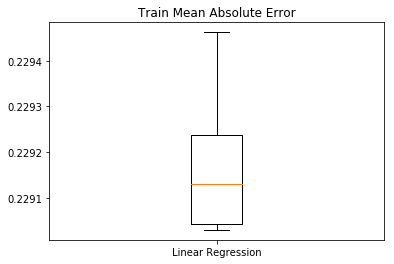

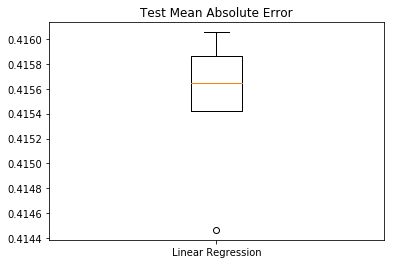

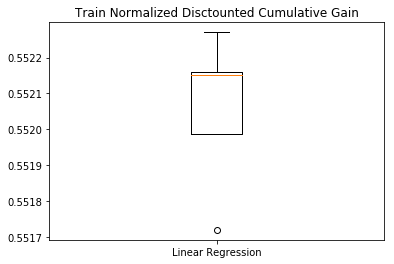

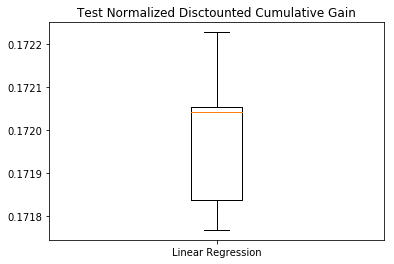

In [267]:
plt.title('Train Mean Absolute Error')
plt.boxplot([train_mae])
plt.xticks([1], ['Linear Regression'])

plt.figure()
plt.title('Test Mean Absolute Error')
plt.boxplot([test_mae])
plt.xticks([1], ['Linear Regression'])

plt.figure()
plt.title('Train Normalized Disctounted Cumulative Gain')
plt.boxplot([train_ndcg])
plt.xticks([1], ['Linear Regression'])

plt.figure()
plt.title('Test Normalized Disctounted Cumulative Gain')
plt.boxplot([test_ndcg])
plt.xticks([1], ['Linear Regression'])

In [193]:
X_test_n = scaler.transform(X_test)

/miniconda2/envs/AML/lib/python3.6/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


In [197]:
lr = LinearRegression().fit(X_train_n, y_train['winPlacePerc'].values)
print("Train r2 score: " + str(lr.score(X_train_n, y_train['winPlacePerc'].values)))
print("Test r2 score: " + str(lr.score(X_test_n, y_test['winPlacePerc'].values)))

Train r2 score: 0.8988101960665728
Test r2 score: 0.8982311115163029


In [207]:
train_predictions = lr.predict(X_train_n)
mergedRank = getWinPlacePerc(y_train, train_predictions, train)
train_predictions_ranked = mergedRank['pr_winPlacePerc'].values

print("mean absolute error: " + str(mean_absolute_error(y_train['winPlacePerc'].values, train_predictions_ranked)))
print("NDCG score: " + str(ndcg(y_train['winPlacePerc'].values, train_predictions_ranked)))

mean absolute error: 0.1692837932183732
NDCG score: 0.678783503675522


In [272]:
np.min(train_predictions)

-3.7439548659947124

In [209]:
test_predictions = lr.predict(X_test_n)
testMergedRank = getWinPlacePerc(y_test, test_predictions, train)
test_predictions_ranked = testMergedRank['pr_winPlacePerc'].values

print("mean absolute error: " + str(mean_absolute_error(y_test['winPlacePerc'].values, test_predictions_ranked)))
print("NDCG score: " + str(ndcg(y_test['winPlacePerc'].values, test_predictions_ranked)))

mean absolute error: 0.32421226492101113
NDCG score: 0.35723734015095016


In [217]:
submission_preds = lr.predict(scaler.transform(group_lvl_features_test[group_lvl_features.columns.intersection(feature_list)]))
testMergedRank = getWinPlacePerc2(group_lvl_features_test, submission_preds, test)
submission_preds_ranked = testMergedRank['pr_winPlacePerc'].values

/miniconda2/envs/AML/lib/python3.6/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


In [218]:
submission_preds_ranked

array([0.32142857, 1.04166667, 0.85714286, ...,        nan,        nan,
              nan])

In [219]:
len(submission_preds_ranked)

1934174

In [220]:
len(submission_preds)

886238

In [247]:
group_lvl_features_test_maxPlace = pd.merge(group_lvl_features_test, test[['Id','groupId','maxPlace']], on='groupId',how='right').drop_duplicates()
submissionMergedRank = getWinPlacePerc(group_lvl_features_test_maxPlace, submission_preds)

In [252]:
submissionMergedRank[['Id','pr_winPlacePerc']].to_csv("submission.csv",index=False)